In [1]:
import torch
torch.cuda.set_device(6)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
use_fp16 = True

# 64*64 config and checkpoint path
base_config = '../config/hana_idea64.yaml'
base_st_path = '/comp_robot/mm_generative/ckpt/idea_art/t5_v2/model-step=616000.ckpt/checkpoint/mp_rank_00_model_states.pt'

# upsample 256*256 config and checkpoint path
upsampler_config = '../config/hana_upsample256.yaml'
upsampler_st_path = '/comp_robot/mm_generative/ckpt/idea_art/upsample256/dalle/model-step=1000000.ckpt/checkpoint/mp_rank_00_model_states.pt'


In [2]:
# 1. (SLOW) LOAD T5 Model
from transformers import T5Tokenizer, T5EncoderModel
import torch
from IPython.display import clear_output 

t5_tokenizer = T5Tokenizer.from_pretrained("t5-11b")
t5_model = T5EncoderModel.from_pretrained("t5-11b")

t5_model.to(device)
t5_model.eval()
clear_output()

In [3]:
# 2. LOAD Base Model
from omegaconf import OmegaConf
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
from IPython.display import clear_output 
import sys, os 
sys.path.append(os.path.abspath('..'))
from model.model_creation import create_gaussian_diffusion
from prompt2prompt.text2im_model import create_model 

# choose model config and checkpoint
cfg = OmegaConf.load(base_config)

# init model and diffusion
model = create_model(**cfg.model)
diffusion = create_gaussian_diffusion(
    steps=cfg.diffusion.steps,
    learn_sigma=cfg.diffusion.learn_sigma,
    sigma_small=cfg.diffusion.sigma_small,
    noise_schedule=cfg.diffusion.noise_schedule,
    use_kl=cfg.diffusion.use_kl,
    predict_xstart=cfg.diffusion.predict_xstart,
    rescale_timesteps=cfg.diffusion.rescale_timesteps,
    rescale_learned_sigmas=cfg.diffusion.rescale_learned_sigmas,
    timestep_respacing=cfg.diffusion.eval_timestep_respacing,
)

# load ckpt
def load_ckpt(model, use_fp16=False):
    if use_fp16:
        model = model.half()
    st = torch.load(base_st_path, map_location='cpu')
    model_state_dict = model.state_dict()
    for name in list(model_state_dict.keys()):
        model_state_dict[name] = st['module']['module.model.' + name]
    model.load_state_dict(model_state_dict)
    return model

base_model = load_ckpt(model, use_fp16=use_fp16).to(device).eval()

In [4]:
# 3. Utils
import copy
import random
import numpy as np
from einops import rearrange

def set_random_seed(seed: int):
    """Set random seed for reproducability."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def get_t5_text_encoding(text):
    text = [text]
    encoding = t5_tokenizer(text,
                            padding='max_length',
                            max_length=256,
                            truncation=True,
                            return_tensors="pt")
    input_ids, attention_mask = encoding.input_ids, encoding.attention_mask
    input_ids = input_ids.cuda()
    attention_mask = attention_mask.cuda()
    with torch.no_grad():
        outputs = t5_model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_states = outputs.last_hidden_state  # [b, 256, 1024]
    attention_mask = attention_mask.bool()
    # just force all embeddings that is padding to be equal to 0.
    last_hidden_states = last_hidden_states.masked_fill(~rearrange(attention_mask, '... -> ... 1'), 0.)
    num_valid_tokens = attention_mask.sum(axis=1).cpu()  # [b]
    return last_hidden_states, num_valid_tokens


def display_sample(sample):
    grid = make_grid(sample, nrow=int(4), padding=0).cpu()
    image = to_pil_image(grid.add(1).div(2).clamp(0, 1))
    return image

In [5]:
# 4.0 Initialize attention controller
from prompt2prompt.utils import AttentionControl
attn_controller = AttentionControl()

In [6]:
# 4.1 Sampling hyperparameters
image_size = 64
guidance_scale = 12.
dynamic_thresholding_percentile = 0.9
seed = 0
set_random_seed(seed)

if cfg.diffusion.eval_timestep_respacing[:4] == 'ddim':
    sampler = diffusion.ddim_sample_loop
else:
    sampler = diffusion.p_sample_loop

In [25]:
# 4.2 Base prompt sampling
base_prompt = "A rhino in the field"
attn_controller.switch_to_write()

  0%|          | 0/250 [00:00<?, ?it/s]

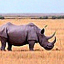

In [26]:
prompt_encoding, _ = get_t5_text_encoding(base_prompt)
if use_fp16:
    prompt_encoding = prompt_encoding.half()
batch_size = prompt_encoding.shape[0]
full_batch_size = batch_size * 2

# Create for the classifier-free guidance (empty)
out_dict = {}
out_dict["text_encodings"] = torch.cat([
    prompt_encoding, torch.zeros_like(prompt_encoding)], dim=0,
)

def model_fn(x_t, ts, **kwargs):
    global guidance_scale
    half = x_t[: len(x_t) // 2]
    combined = torch.cat([half, half], dim=0)
    model_out = base_model(combined, ts, attn_controller=attn_controller, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = torch.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = torch.cat([half_eps, half_eps], dim=0)
    return torch.cat([eps, rest], dim=1)

with torch.no_grad():
    sample = sampler(
        model_fn,
        shape=(full_batch_size, 3, image_size, image_size),
        clip_denoised=True,
        dynamic_threshold=dynamic_thresholding_percentile,
        model_kwargs=out_dict,
        device=device,
        progress=True,
    )[:batch_size]

display_sample(sample)

In [32]:
# 4.3 Edit prompt sampling
edit_prompt = "A zebra in the field"
attn_controller.switch_to_read()

  0%|          | 0/250 [00:00<?, ?it/s]

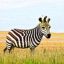

In [33]:
prompt_encoding, _ = get_t5_text_encoding(edit_prompt)
if use_fp16:
    prompt_encoding = prompt_encoding.half()
batch_size = prompt_encoding.shape[0]
full_batch_size = batch_size * 2

# Create for the classifier-free guidance (empty)
out_dict = {}
out_dict["text_encodings"] = torch.cat([prompt_encoding, torch.zeros_like(prompt_encoding)], dim=0)

def model_fn(x_t, ts, **kwargs):
    global guidance_scale
    half = x_t[: len(x_t) // 2]
    combined = torch.cat([half, half], dim=0)
    model_out = base_model(combined, ts, attn_controller=attn_controller, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = torch.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = torch.cat([half_eps, half_eps], dim=0)
    return torch.cat([eps, rest], dim=1)

with torch.no_grad():
    edit_sample = sampler(
        model_fn,
        shape=(full_batch_size, 3, image_size, image_size),
        clip_denoised=True,
        dynamic_threshold=dynamic_thresholding_percentile,
        model_kwargs=out_dict,
        device=device,
        progress=True,
    )[:batch_size]

display_sample(edit_sample)